In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
df_train = pd.read_csv("../input/prostate-cancer-grade-assessment/train.csv")
df_train.head(10)

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0
5,002a4db09dad406c85505a00fb6f6144,karolinska,0,0+0
6,003046e27c8ead3e3db155780dc5498e,karolinska,1,3+3
7,0032bfa835ce0f43a92ae0bbab6871cb,karolinska,1,3+3
8,003a91841da04a5a31f808fb5c21538a,karolinska,1,3+3
9,003d4dd6bd61221ebc0bfb9350db333f,karolinska,1,3+3


In [3]:
train_img_path = "/kaggle/input/prostate-cancer-grade-assessment/train_images"
label_path = "/kaggle/input/prostate-cancer-grade-assessment/train_label_masks"

train_img = [img for img in os.listdir(train_img_path)]
train_label = [label for label in os.listdir(label_path)]

train_img = list(sorted(train_img))
train_label = list(sorted(train_label))

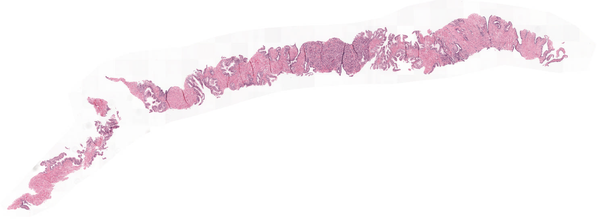

PROVIDED BY: radboud
ISUP Grade: 4, Gleason Grade: 4+4


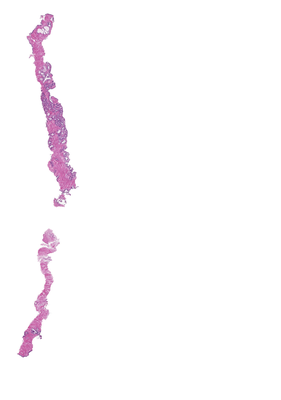

PROVIDED BY: karolinska
ISUP Grade: 1, Gleason Grade: 3+3


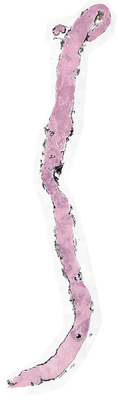

PROVIDED BY: radboud
ISUP Grade: 5, Gleason Grade: 4+5


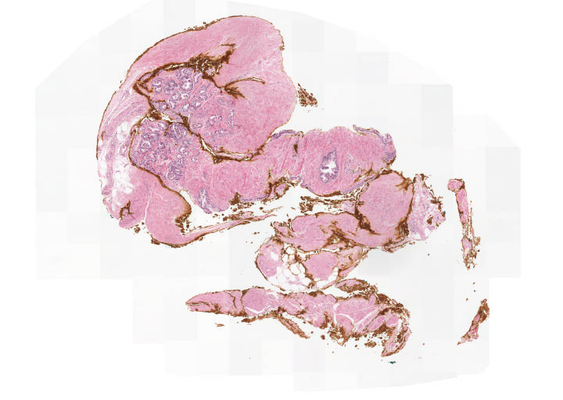

PROVIDED BY: radboud
ISUP Grade: 1, Gleason Grade: 3+3


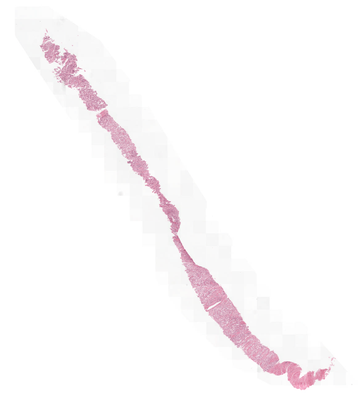

PROVIDED BY: radboud
ISUP Grade: 4, Gleason Grade: 4+4


In [4]:
from matplotlib import rcParams
import openslide
import cv2
from IPython.display import display

# rcParams["figure.figsize"] = 15, 15

for i in range(20, 25):
    img = openslide.OpenSlide(train_img_path + "/" + train_img[i])
    display(img.get_thumbnail(size=(600, 400)))
    img.close()
    d = df_train.loc[df_train["image_id"] == train_img[i][:-5]]
    print(f"PROVIDED BY: {d.data_provider.values[0]}")
    print(f"ISUP Grade: {d.isup_grade.values[0]}, Gleason Grade: {d.gleason_score.values[0]}")

**RADBOUDUMC:**
* 0: background (non tissue) or unknown
* 1: stroma (connective tissue, non-epithelium tissue)
* 2: healthy (benign) epithelium
* 3: cancerous epithelium (Gleason 3)
* 4: cancerous epithelium (Gleason 4)
* 5: cancerous epithelium (Gleason 5)

**KAROLINSKA:**
* 0: background (non tissue) or unknown
* 1: benign tissue (stroma and epithelium combined)
* 2: cancerous tissue (stroma and epithelium combined)

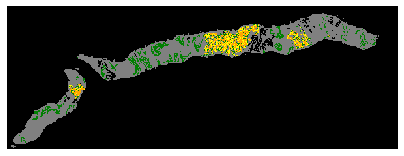

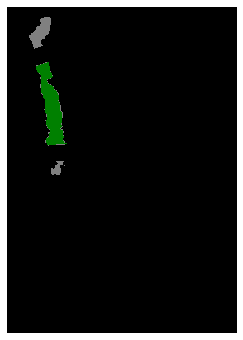

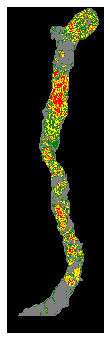

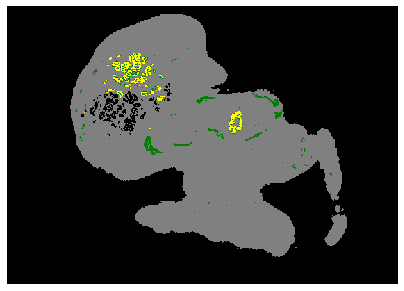

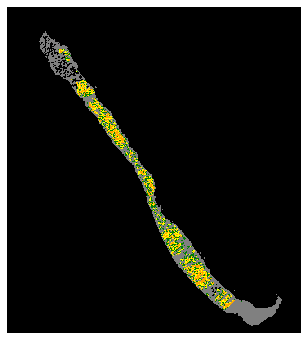

In [5]:
import matplotlib

rcParams["figure.figsize"] = 7, 6

for i in range(20, 25):
    mask = openslide.OpenSlide(label_path + "/" + train_label[i])
    mask = mask.get_thumbnail(size=(600, 400))
    mask = np.asarray(mask)
    mask = mask[:,:,0]
    cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])

    plt.imshow(mask, cmap=cmap, interpolation='nearest', vmin=0, vmax=5)
    plt.axis('off')
    plt.show()
#     mask.close()

## IMAGE PREPROCESSING

In [6]:
SIZE = 200

def preprocessing_img(img):
    slide = openslide.OpenSlide(img)
    img = np.array(slide.get_thumbnail(size=(SIZE, SIZE)))
    img = Image.fromarray(img)
    img = img.resize((SIZE, SIZE))
    img = np.array(img)
    return img

In [7]:
from PIL import Image

img_array = []
for i in range(len(train_img)):
    img = train_img_path + "/" + train_img[i]
    img = preprocessing_img(img)
    img_array.append(img)

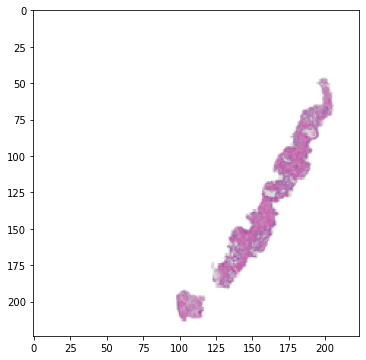

In [8]:
plt.imshow(img_array[1])
plt.show()

In [9]:
from sklearn.preprocessing import LabelBinarizer

train_y = list(df_train['isup_grade'].values)
lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)

In [10]:
train_x = np.reshape(img_array, (len(img_array), 224, 224, 3))

In [11]:
df_test = pd.read_csv("../input/prostate-cancer-grade-assessment/test.csv")
df_test.head(10)

,image_id,data_provider
0,005700be7e06878e6605e7a5a39de1b2,radboud
1,005c6e8877caf724c600fdce5d417d40,karolinska
2,0104f76634ff89bfff1ef0804a95c380,radboud


In [12]:
test_img = [img+".tiff" for img in df_test['image_id'].values]

In [13]:
test_img_path = '../input/prostate-cancer-grade-assessment/test_images'
test_x = []

if os.path.exists(test_img_path):
    for i in range(len(test_img)):
        img = test_img_path + "/" + test_img[i]
        img = preprocessing_img(img)
        test_x.append(img)
    test_x = np.reshape(train_img, (len(test_img), 224, 224, 3))
else:
    test_x = np.random.rand(len(test_img),224, 224, 3)

In [14]:
train_y.sum(axis=0)

array([2892, 2666, 1343, 1242, 1249, 1224])

In [15]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    train_x, train_y, train_size=0.8, random_state=42)

In [16]:
from keras.applications import DenseNet121

densenet = DenseNet121(
    weights = '../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224, 224, 3)
)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as ly
from tensorflow.keras.optimizers import Adam

model = Sequential([
    densenet,
    ly.GlobalAveragePooling2D(),
    ly.Dropout(0.8),
    ly.Dense(6, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.01), metrics=["accuracy"])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 6150      
Total params: 7,043,654
Trainable params: 6,960,006
Non-trainable params: 83,648
_________________________________________________________________


In [19]:
from keras.preprocessing.image import ImageDataGenerator

data = ImageDataGenerator(
    zoom_range = 0.15,
    fill_mode="nearest",
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True
)

data = data.flow(x_train, y_train, batch_size=10, seed=42)

In [ ]:
history = model.fit_generator(
    data, steps_per_epoch=x_train.shape[0] // 10,
    epochs=10,
    validation_data=(x_val, y_val)
)

Epoch 1/10
849/849 [==============================] - 127s 150ms/step - loss: 0.6269 - accuracy: 0.2354 - val_loss: 1.8015 - val_accuracy: 0.2359
Epoch 2/10
849/849 [==============================] - 124s 146ms/step - loss: 0.4632 - accuracy: 0.2629 - val_loss: 0.4677 - val_accuracy: 0.2509
Epoch 3/10
849/849 [==============================] - 126s 149ms/step - loss: 0.4347 - accuracy: 0.2815 - val_loss: 0.4354 - val_accuracy: 0.2679
Epoch 4/10
849/849 [==============================] - 126s 148ms/step - loss: 0.4243 - accuracy: 0.3005 - val_loss: 0.4848 - val_accuracy: 0.1201
Epoch 5/10
849/849 [==============================] - ETA: 0s - loss: 0.4260 - accuracy: 0.2806